# Bitácora properati

In [2]:
pip install ydata_profiling scikit-learn folium openpyxl spacy transformers torch pandas numpy regex unidecode

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\facun\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
!python -m spacy download es_core_news_sm

You should consider upgrading via the 'c:\Users\facun\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.



     --------------------------------------- 12.9/12.9 MB 21.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [4]:
# Importación de librerías
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import re

c:\Users\facun\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Base test
Levanto la base test y dejo los filtros que corresponden: Venta y USD
Con los filtros nos quedamos con **60.319** registros de **85.528** (70.5%)

In [5]:
# Levantamos .csv
df_test = pd.read_csv("/Users/facun/Desktop/AED 2025/Properati/bd_test.csv", sep=';')

# Filter for operation_type = "Venta" and currency = "USD"
df_test = df_test[(df_test['operation_type'] == 'Venta') & (df_test['currency'] == 'USD')]

# Vista inicial
df_test.head()

# Tamaño del dataset
print("Filas:", df_test.shape[0])
print("Columnas:", df_test.shape[1])

# Tipos de variables
df_test.info()

# Resumen con estadísticos principales (cantidad de valores no nulos, media, cuartiles, etc)
df_test.describe().T

Filas: 60319
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
Index: 60319 entries, 0 to 85527
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               60319 non-null  int64  
 1   ad_type          60319 non-null  object 
 2   start_date       60319 non-null  object 
 3   end_date         60319 non-null  object 
 4   created_on       60319 non-null  object 
 5   lat              51736 non-null  object 
 6   lon              51807 non-null  object 
 7   l1               60319 non-null  object 
 8   l2               60319 non-null  object 
 9   l3               57619 non-null  object 
 10  l4               20764 non-null  object 
 11  l5               437 non-null    object 
 12  l6               0 non-null      float64
 13  rooms            46044 non-null  float64
 14  bedrooms         38620 non-null  float64
 15  bathrooms        56172 non-null  float64
 16  surface_total    34537 non-null  floa

,count,mean,std,min,25%,50%,75%,max
id,60319.0,494547.015236,294605.476442,9.0,237974.5,492133.0,752855.5,999986.0
l6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,46044.0,2.999392,1.493668,1.0,2.0,3.0,4.0,35.0
bedrooms,38620.0,2.205256,1.374264,0.0,1.0,2.0,3.0,77.0
bathrooms,56172.0,1.699993,1.022667,1.0,1.0,1.0,2.0,16.0
surface_total,34537.0,242.325477,1601.531668,0.0,52.0,88.0,200.0,100000.0
surface_covered,36650.0,128.991241,618.994208,1.0,47.0,75.0,150.0,58000.0
price,60319.0,235745.780036,339352.329129,0.0,99000.0,155000.0,260000.0,26653528.0


Transformación de las variables

In [6]:
# Convert date columns to datetime objects
df_test['start_date'] = pd.to_datetime(df_test['start_date'], format='%Y-%m-%d', errors='coerce')
df_test['end_date'] = pd.to_datetime(df_test['end_date'], format='%Y-%m-%d', errors='coerce')
df_test['created_on'] = pd.to_datetime(df_test['created_on'], format='%Y-%m-%d', errors='coerce')

# Display the data types to verify the conversion
print(df_test[['start_date', 'end_date', 'created_on']].info())

df_test['start_date'].dt.strftime('%Y/%m/%d').head()
df_test['end_date'].dt.strftime('%Y/%m/%d').head()
df_test['created_on'].dt.strftime('%Y/%m/%d').head()

# Convert 'lat' and 'lon' to numeric, replacing comma with a period
df_test['lat'] = pd.to_numeric(df_test['lat'].str.replace(',', '.'), errors='coerce')
df_test['lon'] = pd.to_numeric(df_test['lon'].str.replace(',', '.'), errors='coerce')

# Display the data types to verify the conversion
print(df_test[['lat', 'lon']].info())

<class 'pandas.core.frame.DataFrame'>
Index: 60319 entries, 0 to 85527
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  60319 non-null  datetime64[ns]
 1   end_date    44344 non-null  datetime64[ns]
 2   created_on  60319 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 1.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 60319 entries, 0 to 85527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     51736 non-null  float64
 1   lon     51807 non-null  float64
dtypes: float64(2)
memory usage: 1.4 MB
None


# Base desarrollo

In [7]:
# Levantamos .csv
df = pd.read_csv("/Users/facun/Desktop/AED 2025/Properati/bd_desarrollo.csv",sep=';')

# Vista inicial
df.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,price
0,556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,"-58,4423994000","-34,5736231000",Argentina,Capital Federal,Colegiales,...,2.0,NaN,NaN,USD,NaN,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta,259000.0
1,192912,Propiedad,2020-06-05,2020-06-08,2020-06-05,"-58,4304928000","-34,6066200000",Argentina,Capital Federal,Almagro,...,2.0,77.0,67.0,USD,NaN,Departamento de 3 ambientes en Venta en Almagro,Excelente departamento de tres ambientes ampli...,Departamento,Venta,235500.0
2,238224,Propiedad,2020-07-01,9999-12-31,2020-07-01,"-58,4917602500","-34,5741233800",Argentina,Capital Federal,Villa Urquiza,...,1.0,60.0,55.0,USD,NaN,Andonaegui 2600 4° - - Departamento en Venta,Excelente 3 ambientes al frente con balcón. Vi...,Departamento,Venta,175000.0
3,521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,"-58,4299830000","-34,6072250000",Argentina,Capital Federal,Almagro,...,1.0,66.0,64.0,USD,NaN,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta,173000.0
4,383947,Propiedad,2019-10-23,2019-11-08,2019-10-23,"-58,4207800000","-34,6086400000",Argentina,Capital Federal,Almagro,...,1.0,55.0,55.0,USD,NaN,Depto.tipo casa de 3 ambientes en Venta en Alm...,"Muy Lindo ph al contrafrente con 2 patios!, 80...",PH,Venta,155000.0


# EDA - Base desarrollo

In [8]:
# Tamaño del dataset
print("Filas:", df.shape[0])
print("Columnas:", df.shape[1])

# Tipos de variables
df.info()

# Resumen con estadísticos principales (cantidad de valores no nulos, media, cuartiles, etc)
df.describe().T

Filas: 879294
Columnas: 25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               879294 non-null  int64  
 1   ad_type          879294 non-null  object 
 2   start_date       879294 non-null  object 
 3   end_date         879294 non-null  object 
 4   created_on       879294 non-null  object 
 5   lat              743531 non-null  object 
 6   lon              744354 non-null  object 
 7   l1               879294 non-null  object 
 8   l2               879294 non-null  object 
 9   l3               827305 non-null  object 
 10  l4               185112 non-null  object 
 11  l5               3781 non-null    object 
 12  l6               0 non-null       float64
 13  rooms            432009 non-null  float64
 14  bedrooms         334687 non-null  float64
 15  bathrooms        681546 non-null  float64
 16  surface_tot

,count,mean,std,min,25%,50%,75%,max
id,879294.0,502302.326894,2.882041e+05,1.0,253101.25,503737.5,752416.75,1.000000e+06
l6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,432009.0,2.866357,1.701833e+00,1.0,2.00,3.0,4.00,4.000000e+01
bedrooms,334687.0,2.084473,2.751976e+00,-13.0,1.00,2.0,3.00,9.000000e+02
bathrooms,681546.0,1.696844,1.071229e+00,1.0,1.00,1.0,2.00,2.000000e+01
surface_total,384422.0,511.374284,4.244219e+03,-200.0,50.00,95.0,277.00,2.000000e+05
surface_covered,373844.0,637.453502,7.981026e+04,-170.0,45.00,75.0,155.00,2.700000e+07
price,838214.0,295447.634787,5.905478e+06,0.0,39000.00,95000.0,205000.00,3.100000e+09


Transformación del tipo de variable

In [9]:
# Convert date columns to datetime objects
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d', errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d', errors='coerce')
df['created_on'] = pd.to_datetime(df['created_on'], format='%Y-%m-%d', errors='coerce')

# Display the data types to verify the conversion
print(df[['start_date', 'end_date', 'created_on']].info())

df['start_date'].dt.strftime('%Y/%m/%d').head()
df['end_date'].dt.strftime('%Y/%m/%d').head()
df['created_on'].dt.strftime('%Y/%m/%d').head()

# Convert 'lat' and 'lon' to numeric, replacing comma with a period
df['lat'] = pd.to_numeric(df['lat'].str.replace(',', '.'), errors='coerce')
df['lon'] = pd.to_numeric(df['lon'].str.replace(',', '.'), errors='coerce')

# Display the data types to verify the conversion
print(df[['lat', 'lon']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   start_date  879294 non-null  datetime64[ns]
 1   end_date    711369 non-null  datetime64[ns]
 2   created_on  879294 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 20.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879294 entries, 0 to 879293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   lat     743531 non-null  float64
 1   lon     744354 non-null  float64
dtypes: float64(2)
memory usage: 13.4 MB
None


## Reporte EDA base original

In [ ]:
## Generate the EDA report
#profile = ProfileReport(df, title="EDA db_desarrollo")
#
## Save the report to an HTML file
#profile.to_file("eda_report_df_desarrollo.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


Tabla de frecuencias

In [10]:
# Frequency tables for selected variables
selected_cols = ['l1','rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered','currency','price_period','operation_type', 'property_type']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df[col].value_counts()
    relative_frequencies = df[col].value_counts(normalize=True) * 100
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

Frequency Table for l1:
                Absolute Frequency  Relative Frequency (%)
l1                                                        
Argentina                   860524               97.865333
Uruguay                      17929                2.039022
Estados Unidos                 783                0.089049
Brasil                          58                0.006596


Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)
rooms                                            
2.0                118344               27.393874
3.0                109046               25.241604
1.0                 84800               19.629221
4.0                 65682               15.203850
5.0                 29186                6.755878
6.0                 12770                2.955957
7.0                  5780                1.337935
8.0                  2802                0.648598
10.0                 1487                0.344206
9.0                  1049                0.

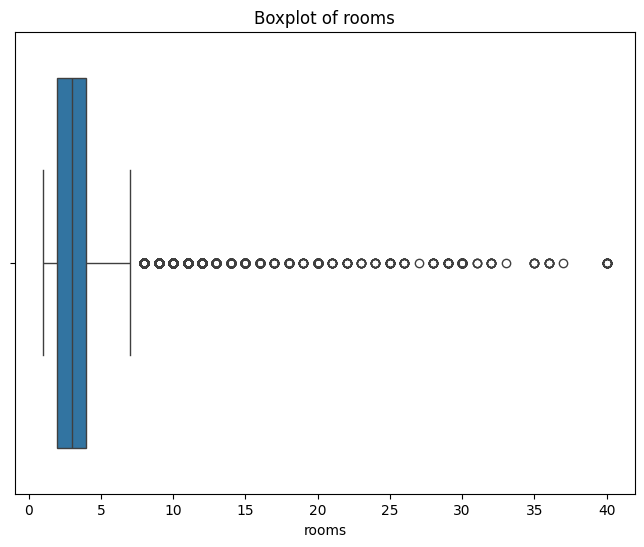

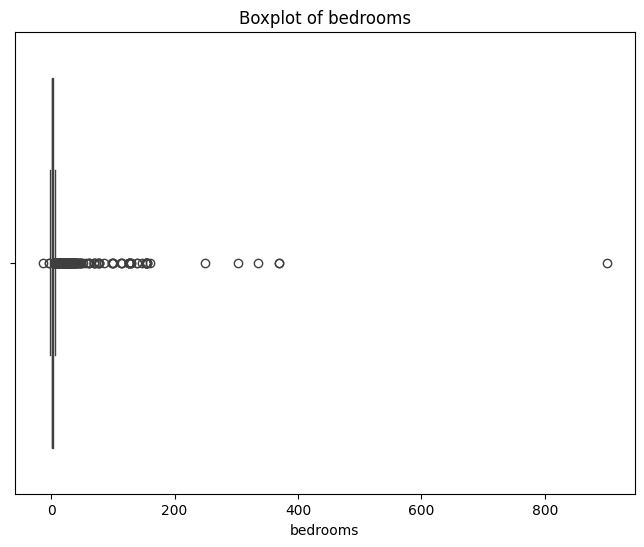

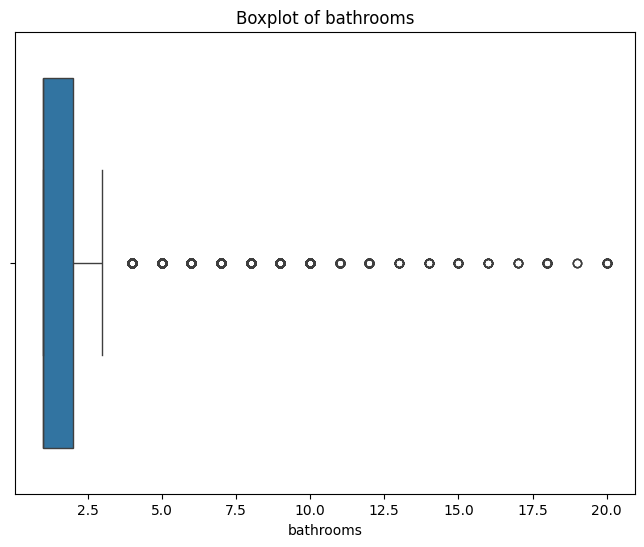

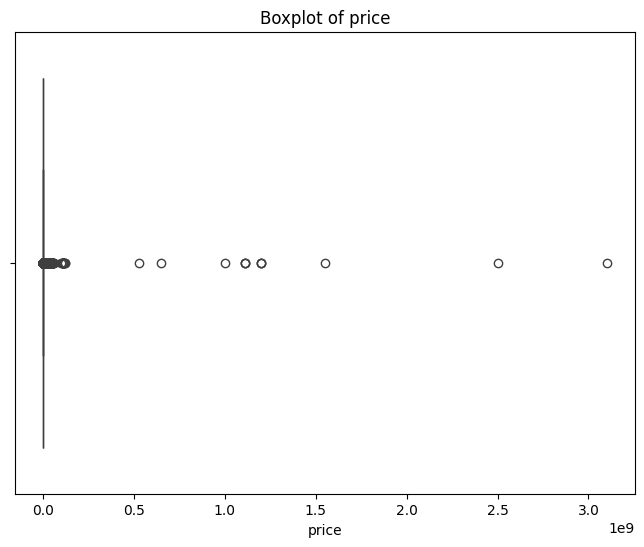

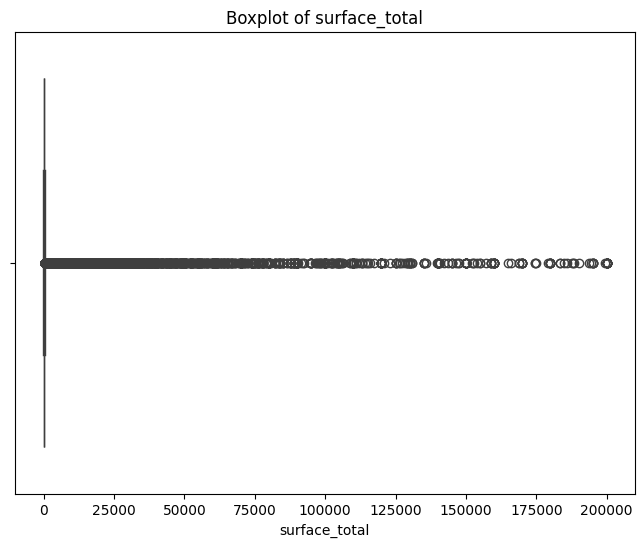

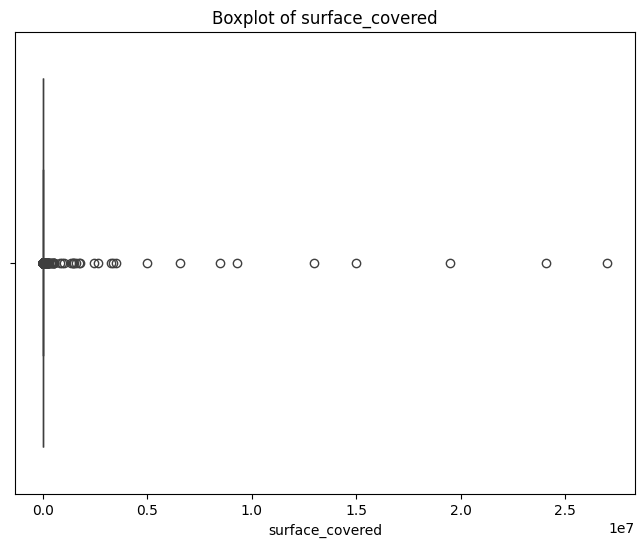

In [11]:
%matplotlib inline
# Select specified numeric columns for visualizations
numeric_cols_selected = ['rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered']

# Generate boxplots for selected numeric variables
for col in numeric_cols_selected:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## Filtros
Originalmete la base train tiene **879.294** registros y 25 variables. Después de aplicar los filtros correspondientes nos quedamos con **289.254** filas (32.9% de los registros)

### operation_type = Ventas

In [12]:
df_ventas = df[df['operation_type'] == 'Venta']
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 679477
Porcentaje sobre el total original (879294): 77.28%


### l1 = Argentina

In [13]:
df_ventas = df_ventas[df_ventas['l1'] == 'Argentina']
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 667853
Porcentaje sobre el total original (879294): 75.95%


### l2 = Capital Federal, Bs.As. G.B.A. Zona Norte, Bs.As. G.B.A. Zona Sur, Bs.As. G.B.A. Zona Oeste, Santa Fe, Córdoba

In [14]:
region = ['Capital Federal','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Oeste','Santa Fe','Córdoba']
df_ventas = df_ventas[df_ventas['l2'].isin(region)]
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 459074
Porcentaje sobre el total original (879294): 52.21%


### property_type = Departamento, Casa, PH, Casa de campo

In [15]:
tipos_validos = ['Departamento', 'Casa', 'PH', 'Casa de campo']
df_ventas_sin_otros = df_ventas[df_ventas['property_type'].isin(tipos_validos)]
# Tamaño del dataset
num_rows = df_ventas.shape[0]
original_rows = 879294
percentage_remaining = (num_rows / original_rows) * 100

print(f"Filas: {num_rows}")
print(f"Porcentaje sobre el total original ({original_rows}): {percentage_remaining:.2f}%")

Filas: 459074
Porcentaje sobre el total original (879294): 52.21%


### DECISIÓN: Quitar las columnas ad_type y l6 porque están vacías

In [16]:
df_ventas_sin_otros = df_ventas_sin_otros.drop(columns=['ad_type', 'l6'], errors='ignore')

In [ ]:
# Frequency tables for selected variables
selected_cols = ['l1','rooms', 'bedrooms', 'bathrooms', 'price', 'surface_total', 'surface_covered','currency','price_period','operation_type', 'property_type']
for col in selected_cols:
    print(f"Frequency Table for {col}:")
    absolute_frequencies = df_ventas_sin_otros[col].value_counts()
    relative_frequencies = df_ventas_sin_otros[col].value_counts(normalize=True) * 100
    frequency_table = pd.DataFrame({
        'Absolute Frequency': absolute_frequencies,
        'Relative Frequency (%)': relative_frequencies
    })
    print(frequency_table)
    print("\n" + "="*50 + "\n")

## Filtro por los l3 que están en la base_test

### OJO: separo el dataset en Currency USD y ARS

In [59]:
moneda = ['USD']
df_ventas_sin_otros_USD = df_ventas_sin_otros[df_ventas_sin_otros['currency'].isin(moneda)]

In [60]:
df_ventas_sin_otros_USD.describe().T

,count,mean,min,25%,50%,75%,max,std
id,266782.0,477296.415883,5.0,215575.0,466586.0,738010.75,999995.0,293620.001206
start_date,266782,2020-01-21 00:46:28.434001920,2019-07-04 00:00:00,2019-10-25 00:00:00,2020-01-28 00:00:00,2020-04-14 00:00:00,2020-07-27 00:00:00,NaN
end_date,188016,2020-03-14 04:41:39.412816128,2019-07-05 00:00:00,2019-12-22 00:00:00,2020-04-02 00:00:00,2020-06-25 00:00:00,2020-09-25 00:00:00,NaN
created_on,266782,2020-01-21 00:46:28.434001920,2019-07-04 00:00:00,2019-10-25 00:00:00,2020-01-28 00:00:00,2020-04-14 00:00:00,2020-07-27 00:00:00,NaN
lat,231845.0,-59.214555,-180.0,-58.740092,-58.482614,-58.413031,-54.13333,1.746567
lon,232226.0,-34.153792,-53.788249,-34.642022,-34.592375,-34.42235,85.051129,1.080694
rooms,220517.0,3.004703,1.0,2.0,3.0,4.0,40.0,1.571738
bedrooms,178384.0,2.175868,-3.0,1.0,2.0,3.0,900.0,2.753886
bathrooms,250228.0,1.690326,1.0,1.0,1.0,2.0,20.0,1.015281
surface_total,161480.0,237.315098,-200.0,50.0,84.0,189.0,200000.0,1866.135924


In [61]:
moneda = ['ARS']
df_ventas_sin_otros_ARS = df_ventas_sin_otros[df_ventas_sin_otros['currency'].isin(moneda)]

In [62]:
df_ventas_sin_otros_ARS.describe().T

,count,mean,min,25%,50%,75%,max,std
id,7813.0,450308.876872,11.0,192390.0,423413.0,670387.0,999771.0,285372.468295
start_date,7813,2020-01-19 00:11:47.743504384,2019-07-04 00:00:00,2019-09-22 00:00:00,2020-01-28 00:00:00,2020-05-04 00:00:00,2020-07-27 00:00:00,NaN
end_date,5550,2020-02-12 20:01:02.270270208,2019-07-06 00:00:00,2019-10-11 06:00:00,2020-02-21 00:00:00,2020-06-02 00:00:00,2020-09-25 00:00:00,NaN
created_on,7813,2020-01-19 00:11:47.743504384,2019-07-04 00:00:00,2019-09-22 00:00:00,2020-01-28 00:00:00,2020-05-04 00:00:00,2020-07-27 00:00:00,NaN
lat,5735.0,-60.726101,-68.886894,-60.69929,-60.656476,-58.912202,-54.570341,1.907884
lon,5747.0,-33.004826,-38.967398,-34.371569,-32.947211,-32.862348,-25.974415,1.176736
rooms,6450.0,2.190388,1.0,1.0,2.0,3.0,14.0,1.376441
bedrooms,5170.0,1.446228,0.0,1.0,1.0,2.0,32.0,0.952697
bathrooms,7248.0,1.173841,1.0,1.0,1.0,1.0,7.0,0.533798
surface_total,4175.0,147.843832,11.0,40.0,53.0,89.0,47019.0,929.770122


Frequency Table for l1:
           Absolute Frequency  Relative Frequency (%)
l1                                                   
Argentina              289254                   100.0


Frequency Table for rooms:
       Absolute Frequency  Relative Frequency (%)
rooms                                            
3.0                 65054               27.246722
2.0                 64543               27.032698
4.0                 41795               17.505099
1.0                 35825               15.004670
5.0                 17702                7.414171
6.0                  7337                3.072973
7.0                  3211                1.344871
8.0                  1510                0.632437
10.0                  719                0.301140
9.0                   593                0.248368
12.0                  137                0.057380
11.0                  105                0.043977
15.0                   43                0.018010
13.0                   39          

## EDA con filtros en país, tipo de propiedad y región (filtro_1)

In [ ]:
## Generate the EDA report
#profile = ProfileReport(df_ventas_sin_otros, title="EDA db_desarrollo_filtro_1")
#
## Save the report to an HTML file
#profile.to_file("eda_report_df_desarrollo_filtro_1.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 30.76it/s]


# Modelo lightgbm base sin modificaciones

In [17]:
# Importación de librerías
import numpy as np
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [18]:
df_train = df_ventas_sin_otros.copy()
df_train_prueba = df_train[['rooms', 'bathrooms', 'bedrooms', 'surface_covered', 'surface_total', 'price']].head(2000)
df_train_prueba = df_train_prueba.fillna(0)

In [ ]:
np.random.seed(42)

# --- Separar features y target ---
y = df_train_prueba['price']
X = df_train_prueba.drop(columns='price')

# --- Validación cruzada ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # --- Escalado opcional (solo train) ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_train.columns)

    ## ACÁ TENGO QUE PONER LAS IMPUTACIONES

    # --- Crear objetos LightGBM ---
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    valid_data = lgb.Dataset(X_valid_scaled, label=y_valid, reference=train_data)

    # --- Parámetros ---
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'seed': 42
    }

    # --- Entrenamiento ---
    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=3)]
    )

    # --- Predicción y RMSE ---
    y_pred = model.predict(X_valid_scaled, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold}: RMSE = {rmse:.4f}")

print(f"RMSE promedio CV: {np.mean(rmse_scores):.4f}")


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 111074
Fold 1: RMSE = 111073.7846
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 84107.9
Fold 2: RMSE = 84107.9278
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 94255
Fold 3: RMSE = 94254.9621
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 76690.1
Fold 4: RMSE = 76690.0662
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 88785.4
Fold 5: RMSE = 88785.4454
RMSE promedio CV: 90982.4372


In [21]:
# Crear listas para almacenar los resultados completos
resultados_completos = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in kf.split(X):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_train.columns)

    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    valid_data = lgb.Dataset(X_valid_scaled, label=y_valid, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'seed': 42
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=3)]
    )

    y_pred = model.predict(X_valid_scaled, num_iteration=model.best_iteration)
    # Recuperar las filas originales usando valid_idx
    fold_result = df_train_prueba.iloc[valid_idx].copy()
    fold_result['observed'] = y_valid.values
    fold_result['predicted'] = y_pred
    fold_result['error'] = y_valid.values - y_pred
    resultados_completos.append(fold_result)

# Concatenar todos los folds
resultados_full = pd.concat(resultados_completos, ignore_index=True)
resultados_full.head()


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 111074
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 84107.9
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 94255
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 76690.1
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 88785.4


,rooms,bathrooms,bedrooms,surface_covered,surface_total,price,observed,predicted,error
0,3.0,1.0,2.0,46.0,49.0,124000.0,124000.0,118351.700709,5648.299291
1,2.0,2.0,1.0,52.0,54.0,104000.0,104000.0,185450.670195,-81450.670195
2,3.0,1.0,2.0,75.0,85.0,230000.0,230000.0,184362.254652,45637.745348
3,3.0,2.0,0.0,85.0,110.0,265000.0,265000.0,281934.377014,-16934.377014
4,2.0,1.0,1.0,43.0,46.0,150000.0,150000.0,116306.953335,33693.046665


# Creación de variables usando NLP

## Superficie total

In [23]:
def extraer_superficie_total_desde_filas(row):
    for texto in [row['description'], row['title']]:
        if pd.isnull(texto):
            continue
        patron = r"(sup(?:erficie)?\.?\s*total(?:\s*por\s*escritura)?[:\s-]*)(\d+[.,]?\d*)"
        coincidencia = re.search(patron, texto, re.IGNORECASE)
        if coincidencia:
            valor = coincidencia.group(2).replace(',', '.')
            try:
                return float(valor)
            except:
                return None
    return None

df_ventas_sin_otros['superficie_total_nlp'] = df_ventas_sin_otros.apply(extraer_superficie_total_desde_filas, axis=1)


## Superficie cubierta

In [24]:
def extraer_superficie_cubierta_desde_filas(row):
    for texto in [row['description'], row['title']]:
        if pd.isnull(texto):
            continue
        patron = r"(sup(?:erficie)?\.?\s*cub(?:ierta)?(?:\s*por\s*escritura)?[:\s-]*|sup\.?\s*cub\.?[:\s-]*)(\d+[.,]?\d*)"
        coincidencia = re.search(patron, texto, re.IGNORECASE)
        if coincidencia:
            valor = coincidencia.group(2).replace(',', '.')
            try:
                return float(valor)
            except:
                return None
    return None

df_ventas_sin_otros['superficie_cubierta_nlp'] = df_ventas_sin_otros.apply(extraer_superficie_cubierta_desde_filas, axis=1)

## Cantidad de ambientes

In [25]:
def extraer_ambientes_desde_filas(row):
    for texto in [row['description'], row['title']]:
        if pd.isnull(texto):
            continue
        # Busca patrones como "X ambientes", "X amb.", "X amb", "X ambientes amplios", etc.
        patron = r"(\d+)[\s\-]*(ambientes|amb\.?|ambiente)"
        coincidencia = re.search(patron, texto, re.IGNORECASE)
        if coincidencia:
            try:
                return float(coincidencia.group(1))
            except:
                return None
    return None

df_ventas_sin_otros['ambientes_nlp'] = df_ventas_sin_otros.apply(extraer_ambientes_desde_filas, axis=1)

## Cantidad de baños

In [26]:
def extraer_banos_desde_filas(row):
    for texto in [row['description'], row['title']]:
        if pd.isnull(texto):
            continue
        # Busca patrones como "X baños", "X baño", "X baños completos", etc.
        patron = r"(\d+)[\s\-]*(baños|baño)"
        coincidencia = re.search(patron, texto, re.IGNORECASE)
        if coincidencia:
            try:
                return float(coincidencia.group(1))
            except:
                return None
    return None

df_ventas_sin_otros['banos_nlp'] = df_ventas_sin_otros.apply(extraer_banos_desde_filas, axis=1)

## Flag más de una propiedad

In [ ]:
def flag_multipropiedad(row):
    patrones = [
        r"(\bvarias\b|\bvarios\b|\bmúltiples\b|\bmultiple\b|\bmultiplas\b)",  # varias/varios/múltiples
        r"(\bconjunto\b|\bconjuntos\b)",  # conjunto de propiedades
        r"(\bideal\b.*\bconstructor\b)",  # ideal constructor
        r"(\bideal\b.*\bemprendimiento\b)",  # ideal emprendimiento
        r"(\bterrenos\b|\blotes\b|\bgalpones\b|\bdepartamentos\b|\bcasas\b|\bphs\b)",  # plural de tipos
        r"(\bse venden\b|\bse alquilan\b|\bventa en block\b|\ben block\b)",  # block
        r"(\bmanzana\b.*\bcompleta\b)",  # manzana completa
        r"(\bfracciones\b|\bfraccion\b)",  # fracciones
        r"(\bph\b.*\bcon\b.*\bdepartamentos\b)",  # ph con departamentos
        r"(\b2\b.*\bpropiedades\b|\b2\b.*\bcasas\b|\b2\b.*\bdepartamentos\b)",  # 2 propiedades/casas/departamentos
        r"(\b3\b.*\bpropiedades\b|\b3\b.*\bcasas\b|\b3\b.*\bdepartamentos\b)",  # 3 propiedades/casas/departamentos
        r"(\b4\b.*\bpropiedades\b|\b4\b.*\bcasas\b|\b4\b.*\bdepartamentos\b)",  # 4 propiedades/casas/departamentos
        r"(\b5\b.*\bpropiedades\b|\b5\b.*\bcasas\b|\b5\b.*\bdepartamentos\b)",  # 5 propiedades/casas/departamentos
        r"(\b6\b.*\bpropiedades\b|\b6\b.*\bcasas\b|\b6\b.*\bdepartamentos\b)",  # 6 propiedades/casas/departamentos
        r"(\b7\b.*\bpropiedades\b|\b7\b.*\bcasas\b|\b7\b.*\bdepartamentos\b)",  # 7 propiedades/casas/departamentos
        r"(\b8\b.*\bpropiedades\b|\b8\b.*\bcasas\b|\b8\b.*\bdepartamentos\b)",  # 8 propiedades/casas/departamentos
        r"(\b9\b.*\bpropiedades\b|\b9\b.*\bcasas\b|\b9\b.*\bdepartamentos\b)",  # 9 propiedades/casas/departamentos
        r"(\b10\b.*\bpropiedades\b|\b10\b.*\bcasas\b|\b10\b.*\bdepartamentos\b)",  # 10 propiedades/casas/departamentos
    ]
    texto = f"{row['description']} {row['title']}".lower() if pd.notnull(row['description']) or pd.notnull(row['title']) else ""
    for patron in patrones:
        if re.search(patron, texto):
            return 1
    return 0

df_ventas_sin_otros['flag_multipropiedad'] = df_ventas_sin_otros.apply(flag_multipropiedad, axis=1)

# Chequeos

## lat y lon
Errores en localidad: 289254

In [53]:
# --- Opción A COMPLETA: validar l3 contra localidades del IGN (solo localidad) ---

import geopandas as gpd
import pandas as pd
import numpy as np
import unicodedata
from shapely.geometry import Point

# ---------- helpers ----------
def norm(x):
    if pd.isna(x): 
        return None
    x = str(x).strip().lower()
    # quitar acentos
    x = ''.join(c for c in unicodedata.normalize('NFD', x)
                if unicodedata.category(c) != 'Mn')
    return x

# ---------- 1) GeoDataFrame con tus propiedades en EPSG:4326 ----------
gdf = gpd.GeoDataFrame(
    df_ventas_sin_otros.copy(),
    geometry=gpd.points_from_xy(df_ventas_sin_otros.lon, df_ventas_sin_otros.lat),
    crs="EPSG:4326"
)

# (opcional) corregir lat/lon invertidas antes del join
lat_ok = gdf.geometry.y.between(-56, -22)
lon_ok = gdf.geometry.x.between(-75, -53)
mask_swap = (~lat_ok) & (~lon_ok) & gdf.geometry.y.between(-75, -53) & gdf.geometry.x.between(-56, -22)
if mask_swap.any():
    gdf.loc[mask_swap, "geometry"] = [
        Point(y, x) for x, y in zip(gdf.loc[mask_swap, "geometry"].x,
                                    gdf.loc[mask_swap, "geometry"].y)
    ]

# ---------- 2) Cargar LOCALIDADES (puntos) del IGN (solo nombre y geometría) ----------
url_loc = "https://infra.datos.gob.ar/georef-dev/localidades.geojson"
localidades = gpd.read_file(url_loc)[["nombre", "geometry"]].copy()
localidades["loc_n"] = localidades["nombre"].apply(norm)

# ---------- 3) PROYECTAR A METROS y hacer sjoin_nearest con distancia en metros ----------
gdf_m  = gdf.to_crs(3857)
loc_m  = localidades.to_crs(3857)

# Join por vecino más cercano (distancia queda en 'dist_m' directamente en metros)
gdf_loc_m = gpd.sjoin_nearest(gdf_m, loc_m, how="left", distance_col="dist_m")

# ---------- 4) Comparar nombres normalizados (l3 vs IGN) ----------
# (tomamos 'nombre' y 'loc_n' que vinieron del right join)
gdf_loc_m["l3_n"]  = gdf_loc_m["l3"].apply(norm)
gdf_loc_m["coincide_loc_nombre"] = (gdf_loc_m["l3_n"] == gdf_loc_m["loc_n"])

# ---------- 5) Umbral de distancia y flag final ----------
UMBRAL_M = 25_000  # 25 km (ajustá: AMBA 5–10 km; interior 25–50 km)
gdf_loc_m["dentro_umbral"] = gdf_loc_m["dist_m"] <= UMBRAL_M

# Coincide si el nombre matchea y la distancia es razonable
gdf_loc_m["coincide_loc"] = gdf_loc_m["coincide_loc_nombre"] & gdf_loc_m["dentro_umbral"]

# ---------- 6) Métricas ----------
total = len(gdf_loc_m)
sin_match = gdf_loc_m["loc_n"].isna().sum()
errores_nombre = (~gdf_loc_m["coincide_loc_nombre"]).sum()
lejos = (~gdf_loc_m["dentro_umbral"]).sum()
errores_final = (~gdf_loc_m["coincide_loc"]).sum()

print(f"Total registros: {total}")
print(f"Sin localidad asignada (NaN): {sin_match}")
print(f"No coinciden por nombre (l3 vs IGN): {errores_nombre}")
print(f"Fuera de umbral de distancia ({UMBRAL_M/1000:.0f} km): {lejos}")
print(f"Errores finales (nombre no coincide o muy lejos): {errores_final}")

# ---------- 7) Resumen por l3 declarada ----------
resumen = (gdf_loc_m
           .assign(l3_show=gdf_loc_m["l3"].fillna("desconocida"))
           .groupby("l3_show")
           .agg(total=("l3_show", "size"),
                no_coinciden=("coincide_loc", lambda s: (~s).sum()))
           .sort_values("no_coinciden", ascending=False))
print(resumen.head(20))

# ---------- 8) Muestra de casos problemáticos ----------
cols_err = [c for c in ["l3", "nombre", "dist_m", "coincide_loc_nombre", "dentro_umbral"] if c in gdf_loc_m.columns]
muestra_errores = gdf_loc_m.loc[~gdf_loc_m["coincide_loc"], cols_err].head(20)
print(muestra_errores)


Total registros: 289254
Sin localidad asignada (NaN): 38430
No coinciden por nombre (l3 vs IGN): 199257
Fuera de umbral de distancia (25 km): 38476
Errores finales (nombre no coincide o muy lejos): 199257
                 total  no_coinciden
l3_show                             
Tigre            16709         14143
desconocida      10619         10619
Rosario          35871         10340
Almagro           8074          8074
Villa Crespo      7542          7542
Belgrano          7513          7513
La Matanza        6965          6638
Lomas de Zamora  11582          6497
Caballito         6301          6301
Pilar             7691          6256
La Plata         10200          6255
Escobar           5303          5152
San Isidro        5695          4984
Recoleta          4749          4749
Morón             6481          3987
Tres de Febrero   4532          3862
Vicente López     5249          3753
Lanús             4838          3610
Ituzaingó         4038          3536
Quilmes           

In [46]:
df_ventas_sin_otros.head(1)

,id,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,title,description,property_type,operation_type,price,superficie_total_nlp,superficie_cubierta_nlp,ambientes_nlp,banos_nlp,flag_multipropiedad
0,556713,2019-11-29,NaT,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,NaN,...,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta,259000.0,96.47,NaN,4.0,NaN,0


Errores en provincia

In [ ]:
import geopandas as gpd
import pandas as pd
import unicodedata
import numpy as np

# ---- helpers ----
def norm(x):
    if pd.isna(x): return None
    x = str(x).strip().lower()
    x = ''.join(c for c in unicodedata.normalize('NFD', x) if unicodedata.category(c) != 'Mn')
    return x

# equivalencias comunes (podés sumar más)
ALIASES = {
    "caba": "ciudad autonoma de buenos aires",
    "capital federal": "ciudad autonoma de buenos aires",
    "buenos aires (caba)": "ciudad autonoma de buenos aires",
    "bs as": "buenos aires",
}

def map_alias(x):
    if x is None: return None
    return ALIASES.get(x, x)

# ---- 1) GeoDataFrame de tus propiedades ----
gdf = gpd.GeoDataFrame(
    df_ventas_sin_otros.copy(),
    geometry=gpd.points_from_xy(df_ventas_sin_otros.lon, df_ventas_sin_otros.lat),
    crs="EPSG:4326"
)

# (opcional) detectar lat/lon invertidas y corregir automáticamente
lat_ok = gdf["geometry"].y.between(-56, -22)
lon_ok = gdf["geometry"].x.between(-75, -53)
mask_swap = (~lat_ok) & (~lon_ok) & gdf["geometry"].y.between(-75, -53) & gdf["geometry"].x.between(-56, -22)
gdf.loc[mask_swap, "geometry"] = gpd.points_from_xy(gdf.loc[mask_swap, "geometry"].y,
                                                    gdf.loc[mask_swap, "geometry"].x, crs="EPSG:4326")

# ---- 2) Provincias (polígonos) desde API oficial ----
url_prov = "https://apis.datos.gob.ar/georef/api/v2.0/provincias.geojson"
provincias = gpd.read_file(url_prov)[["nombre", "geometry"]]

# normalizar nombre de provincia del shapefile
provincias["prov_n"] = provincias["nombre"].apply(norm).apply(map_alias)

# ---- 3) Spatial join: punto dentro de polígono de provincia ----
gdf_p = gpd.sjoin(gdf, provincias[["prov_n", "geometry"]], how="left", predicate="within")

# ---- 4) Normalizar l2 y comparar ----
gdf_p["l2_n"] = gdf_p["l2"].apply(norm).apply(map_alias)
gdf_p["fuera_arg"] = gdf_p["prov_n"].isna()
gdf_p["coincide_prov"] = (~gdf_p["fuera_arg"]) & (gdf_p["l2_n"] == gdf_p["prov_n"])

# ---- 5) Métricas básicas ----
total = len(gdf_p)
errores_fuera = gdf_p["fuera_arg"].sum()
errores_prov = (~gdf_p["coincide_prov"]).sum()

print("Total registros:", total)
print("Fuera de Argentina (sin provincia):", errores_fuera)
print("Errores de provincia (incluye fuera_arg):", errores_prov)

# ---- 6) Resumen por provincia declarada ----
resumen = (gdf_p
           .assign(l2_show=gdf_p["l2_n"].fillna("desconocida"))
           .groupby("l2_show")
           .agg(total=("l2_show", "size"),
                no_coinciden=("coincide_prov", lambda s: (~s).sum()))
           .sort_values("no_coinciden", ascending=False))
print(resumen.head(15))


Total registros: 289254
Fuera de Argentina (sin provincia): 38773
Errores de provincia (incluye fuera_arg): 144715
                                 total  no_coinciden
l2_show                                             
bs.as. g.b.a. zona norte         50015         50015
bs.as. g.b.a. zona sur           46888         46888
bs.as. g.b.a. zona oeste         27575         27575
ciudad autonoma de buenos aires  99858         10480
santa fe                         42172          8054
cordoba                          22746          1703


## surface_total

# Modelo lightgbm base con ambientes

In [47]:
df_train = df_ventas_sin_otros.copy()
df_train_prueba = df_train[['rooms','ambientes_nlp', 'bathrooms', 'bedrooms', 'surface_covered', 'surface_total', 'price']].head(2000)
df_train_prueba = df_train_prueba.fillna(0)

In [48]:
np.random.seed(42)

# --- Separar features y target ---
y = df_train_prueba['price']
X = df_train_prueba.drop(columns='price')

# --- Validación cruzada ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # --- Escalado opcional (solo train) ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_train.columns)

    # --- Crear objetos LightGBM ---
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    valid_data = lgb.Dataset(X_valid_scaled, label=y_valid, reference=train_data)

    # --- Parámetros ---
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'seed': 42
    }

    # --- Entrenamiento ---
    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=3)]
    )

    # --- Predicción y RMSE ---
    y_pred = model.predict(X_valid_scaled, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold}: RMSE = {rmse:.4f}")

print(f"RMSE promedio CV: {np.mean(rmse_scores):.4f}")

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 111662
Fold 1: RMSE = 111662.1215
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 85568.3
Fold 2: RMSE = 85568.3199
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 93481.8
Fold 3: RMSE = 93481.7891
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 76650.3
Fold 4: RMSE = 76650.2989
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 86864.7
Fold 5: RMSE = 86864.7067
RMSE promedio CV: 90845.4472


# NO FUNCIONA: Modelo lightgbm base con ambientes y filtrando la base por currency USD

In [51]:
df_train = df_ventas_sin_otros[df_ventas_sin_otros['currency'] == 'USD'].copy()
df_train_prueba = df_train[['rooms','ambientes_nlp', 'bathrooms', 'bedrooms', 'surface_covered', 'surface_total', 'price']].head(2000)
df_train_prueba = df_train_prueba.fillna(0)

In [52]:
np.random.seed(42)

# --- Separar features y target ---
y = df_train_prueba['price']
X = df_train_prueba.drop(columns='price')

# --- Validación cruzada ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # --- Escalado opcional (solo train) ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_train.columns)

    # --- Crear objetos LightGBM ---
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    valid_data = lgb.Dataset(X_valid_scaled, label=y_valid, reference=train_data)

    # --- Parámetros ---
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'verbose': -1,
        'seed': 42
    }

    # --- Entrenamiento ---
    model = lgb.train(
        params,
        train_data,
        num_boost_round=200,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=3)]
    )

    # --- Predicción y RMSE ---
    y_pred = model.predict(X_valid_scaled, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    rmse_scores.append(rmse)
    print(f"Fold {fold}: RMSE = {rmse:.4f}")

print(f"RMSE promedio CV: {np.mean(rmse_scores):.4f}")

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 111662
Fold 1: RMSE = 111662.1215
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 85568.3
Fold 2: RMSE = 85568.3199
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 93481.8
Fold 3: RMSE = 93481.7891
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 76650.3
Fold 4: RMSE = 76650.2989
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 86864.7
Fold 5: RMSE = 86864.7067
RMSE promedio CV: 90845.4472
